# Improvement through data driven Marginals

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib import style
import itertools
style.use('ggplot')
plt.rc('text', usetex=True)
print("Succesfully loaded")
#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 15,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

Succesfully loaded


C:\Users\Julian\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


First, we import the csv files containing the data (Company1 = Apple, Company2 = Microsoft)

In [2]:
company_1_t1_call = pd.read_csv('csv/company_1_t1_call.csv')
company_1_t2_call = pd.read_csv('csv/company_1_t2_call.csv')
company_2_t1_call = pd.read_csv('csv/company_2_t1_call.csv')
company_2_t2_call = pd.read_csv('csv/company_2_t2_call.csv')
company_1_t1_put = pd.read_csv('csv/company_1_t1_put.csv')
company_1_t2_put = pd.read_csv('csv/company_1_t2_put.csv')
company_2_t1_put = pd.read_csv('csv/company_2_t1_put.csv')
company_2_t2_put = pd.read_csv('csv/company_2_t2_put.csv')

Next, we want to derive the corresponding marginals.
According to Breeden-Litzenberger, and by applying finite differences, we have
$$
prob(K) \approx \frac{C(K_{i+1},t)-2C(K_{i},t)+C(K_{i-1},t)}{(K_{i+1}-K_{i})(K_{i}-K_{i-1})}= \frac{P(K_{i+1},t)-2P(K_{i},t)+P(K_{i-1},t)}{(K_{i+1}-K_{i})(K_{i}-K_{i-1})}
$$
We leave out the first and last strike.

We then normalize the sum of probabilities

In [4]:
def prices_to_density(strikes_call,prices_call,strikes_put,prices_put,finite_differences = True):
    probs = []
    strikes = []
    # First Stike
    probs.append(0)
    strikes.append(strikes_put[0])
    if finite_differences:
        #Loop over Put Options 
        for i in range(1,len(strikes_put)-1):
            probs.append((prices_put[i+1]-2*prices_put[i]+prices_put[i-1])/((strikes_put[i+1]-strikes_put[i])*(strikes_put[i]-strikes_put[i-1])))
            strikes.append(strikes_put[i])
        #Loop over Call Options 
        for i in range(1,len(strikes_call)-1):
            probs.append((prices_call[i+1]-2*prices_call[i]+prices_call[i-1])/((strikes_call[i+1]-strikes_call[i])*(strikes_call[i]-strikes_call[i-1])))
            strikes.append(strikes_call[i])
    else:
        #Loop over Put Options 
        for i in range(1,len(strikes_put)-1):
            probs.append((prices_put[i+1]-prices_put[i])/(strikes_put[i+1]-strikes_put[i])-(prices_put[i]-prices_put[i-1])/(strikes_put[i]-strikes_put[i-1]))
            strikes.append(strikes_put[i])
        #Loop over Call Options 
        for i in range(1,len(strikes_call)-1):
            probs.append((prices_call[i+1]-prices_call[i])/(strikes_call[i+1]-strikes_call[i])-(prices_call[i]-prices_call[i-1])/(strikes_call[i]-strikes_call[i-1]))
            strikes.append(strikes_call[i])
    # Last Strike
    probs.append(0)
    strikes.append(strikes_call[-1])
    #normalize
    sum_p = sum(probs)
    probs = [p/sum_p for p in probs]
    return strikes, probs

Clean the call option prices for non-decreasing prices

In [5]:
def clean_call_prices(list_of_strikes,list_of_prices):
    while(any(np.diff(np.array(list_of_prices))>0)):
        violation_index = 1000000000
        for i in range(1,len(list_of_strikes)):
            if list_of_prices[i]>list_of_prices[i-1]:
                violation_index = i
                break
        list_of_strikes = [list_of_strikes[i] for i in range(len(list_of_strikes)) if i != violation_index]
        list_of_prices  = [list_of_prices [i] for i in range(len(list_of_prices )) if i != violation_index]
    return list_of_strikes, list_of_prices

In [6]:
company_1_t1_call_STRIKE_PRC, company_1_t1_call_MID = clean_call_prices(list(company_1_t1_call.STRIKE_PRC),
                                                                        list(company_1_t1_call.MID))
company_2_t1_call_STRIKE_PRC, company_2_t1_call_MID = clean_call_prices(list(company_2_t1_call.STRIKE_PRC),
                                                                        list(company_2_t1_call.MID))
company_1_t2_call_STRIKE_PRC, company_1_t2_call_MID = clean_call_prices(list(company_1_t2_call.STRIKE_PRC),
                                                                        list(company_1_t2_call.MID))
company_2_t2_call_STRIKE_PRC, company_2_t2_call_MID = clean_call_prices(list(company_2_t2_call.STRIKE_PRC),
                                                                        list(company_2_t2_call.MID))

We proceed similarly for put options

In [7]:
def clean_put_prices(list_of_strikes,list_of_prices):
    while(any(np.diff(np.array(list_of_prices))<0)):
        violation_index = 1000000000
        for i in range(1,len(list_of_strikes)):
            if list_of_prices[i]<list_of_prices[i-1]:
                violation_index = i
                break
        list_of_strikes = [list_of_strikes[i] for i in range(len(list_of_strikes)) if i != violation_index]
        list_of_prices  = [list_of_prices [i] for i in range(len(list_of_prices )) if i != violation_index]
    return list_of_strikes, list_of_prices

In [8]:
company_1_t1_put_STRIKE_PRC, company_1_t1_put_MID = clean_put_prices(list(company_1_t1_put.STRIKE_PRC),
                                                                        list(company_1_t1_put.MID))
company_2_t1_put_STRIKE_PRC, company_2_t1_put_MID = clean_put_prices(list(company_2_t1_put.STRIKE_PRC),
                                                                        list(company_2_t1_put.MID))
company_1_t2_put_STRIKE_PRC, company_1_t2_put_MID = clean_put_prices(list(company_1_t2_put.STRIKE_PRC),
                                                                        list(company_1_t2_put.MID))
company_2_t2_put_STRIKE_PRC, company_2_t2_put_MID = clean_put_prices(list(company_2_t2_put.STRIKE_PRC),
                                                                        list(company_2_t2_put.MID))

We continue cleaning by checking the convexity conditions, i.e. we check that
$$ \frac{C(K_{i+1},t)-C(K_{i},t)}{K_{i+1}-K_{i}}
$$
as well as
$$ \frac{P(K_{i+1},t)-P(K_{i},t)}{K_{i+1}-K_{i}}
$$
are increasing functions in $K_i$.
We leave out the first and last strike.

We then normalize the sum of probabilities

In [9]:
def clean_prices_2(list_of_strikes,list_of_prices,finite_differences = True):
    if finite_differences:
        slope =  [(list_of_prices[i+1]-2*list_of_prices[i]+list_of_prices[i-1])/((list_of_strikes[i+1]-list_of_strikes[i])*(list_of_strikes[i]-list_of_strikes[i-1])) for i in range(1,len(list_of_strikes)-1)]
    else:
        slope = [(list_of_prices[i+1]-list_of_prices[i])/(list_of_strikes[i+1]-list_of_strikes[i])-(list_of_prices[i]-list_of_prices[i-1])/(list_of_strikes[i]-list_of_strikes[i-1]) for i in range(1,len(list_of_strikes)-1)]      
    while(any((np.array(slope))<0)):
        violation_index = 1000000000
        for i in range(len(list_of_strikes)-2):
            if slope[i]<0:
                violation_index = i+2
                break
        list_of_strikes = [list_of_strikes[i] for i in range(len(list_of_strikes)) if i != violation_index]
        list_of_prices  = [list_of_prices [i] for i in range(len(list_of_prices )) if i != violation_index]
        if finite_differences:
            slope =  [(list_of_prices[i+1]-2*list_of_prices[i]+list_of_prices[i-1])/((list_of_strikes[i+1]-list_of_strikes[i])*(list_of_strikes[i]-list_of_strikes[i-1])) for i in range(1,len(list_of_strikes)-1)]
        else:
            slope = [(list_of_prices[i+1]-list_of_prices[i])/(list_of_strikes[i+1]-list_of_strikes[i])-(list_of_prices[i]-list_of_prices[i-1])/(list_of_strikes[i]-list_of_strikes[i-1]) for i in range(1,len(list_of_strikes)-1)]      

    return list_of_strikes, list_of_prices

In [10]:
 company_1_t1_call_STRIKE_PRC, company_1_t1_call_MID = clean_prices_2(company_1_t1_call_STRIKE_PRC,
                                                                         company_1_t1_call_MID)
 company_2_t1_call_STRIKE_PRC, company_2_t1_call_MID = clean_prices_2(company_2_t1_call_STRIKE_PRC,
                                                                         company_2_t1_call_MID)
 company_1_t2_call_STRIKE_PRC, company_1_t2_call_MID = clean_prices_2(company_1_t2_call_STRIKE_PRC,
                                                                         company_1_t2_call_MID)
 company_2_t2_call_STRIKE_PRC, company_2_t2_call_MID = clean_prices_2(company_2_t2_call_STRIKE_PRC,
                                                                         company_2_t2_call_MID)
 company_1_t1_put_STRIKE_PRC, company_1_t1_put_MID = clean_prices_2(company_1_t1_put_STRIKE_PRC,
                                                                         company_1_t1_put_MID)
 company_2_t1_put_STRIKE_PRC, company_2_t1_put_MID = clean_prices_2(company_2_t1_put_STRIKE_PRC,
                                                                         company_2_t1_put_MID)
 company_1_t2_put_STRIKE_PRC, company_1_t2_put_MID = clean_prices_2(company_1_t2_put_STRIKE_PRC,
                                                                         company_1_t2_put_MID)
 company_2_t2_put_STRIKE_PRC, company_2_t2_put_MID = clean_prices_2(company_2_t2_put_STRIKE_PRC,
                                                                         company_2_t2_put_MID)

Convert the prices to probabilities

In [11]:
v11, p11 = prices_to_density(company_1_t1_call_STRIKE_PRC,company_1_t1_call_MID,
                             company_1_t1_put_STRIKE_PRC,company_1_t1_put_MID)
v12, p12 = prices_to_density(company_2_t1_call_STRIKE_PRC,company_2_t1_call_MID,
                            company_2_t1_put_STRIKE_PRC,company_2_t1_put_MID)
v21, p21 = prices_to_density(company_1_t2_call_STRIKE_PRC,company_1_t2_call_MID,
                            company_1_t2_put_STRIKE_PRC,company_1_t2_put_MID)
v22, p22 = prices_to_density(company_2_t2_call_STRIKE_PRC,company_2_t2_call_MID,
                            company_2_t2_put_STRIKE_PRC,company_2_t2_put_MID)

Adjusting the means

In [12]:
p11=[p/sum(p11) for p in p11]
p12=[p/sum(p12) for p in p12]
p21=[p/sum(p21) for p in p21]
p22=[p/sum(p22) for p in p22]


mean_11 = sum([v*p for v,p in zip(v11,p11)])
mean_21 = sum([v*p for v,p in zip(v21,p21)])
mean_12 = sum([v*p for v,p in zip(v12,p12)])
mean_22 = sum([v*p for v,p in zip(v22,p22)])

v11 = [v + 0.5*(mean_21-mean_11) for v in v11]
v21 = [v + 0.5*(mean_11-mean_21) for v in v21]
v12 = [v + 0.5*(mean_22-mean_12) for v in v12]
v22 = [v + 0.5*(mean_12-mean_22) for v in v22]

Plot the corresponding densities of the marginals

In [13]:
def use_same_grid(v1,p1,v2,p2):
    start = min(min(v1),min(v2))
    end = max(max(v1),max(v2))
    x = np.sort(np.concatenate((v1,v2)))
    v1 = np.concatenate(([start],v1,[end]))
    p1 = np.concatenate(([0],p1,[0]))
    v2 = np.concatenate(([start],v2,[end]))
    p2 = np.concatenate(([0],p2,[0]))
    f1 = interp1d(v1, p1, kind='linear')    
    f2 = interp1d(v2, p2, kind='linear')
    p1 = f1(x)
    p2 = f2(x)
    v1 = x
    v2 = x 
    p1 = p1/sum(p1)
    p2 = p2/sum(p2)
    return v1,p1,v2,p2

In [14]:
# Get new marginals on the same grid
vv11,pp11,vv21,pp21 = use_same_grid(v11,p11,v21,p21)
vv12,pp12,vv22,pp22 = use_same_grid(v12,p12,v22,p22)

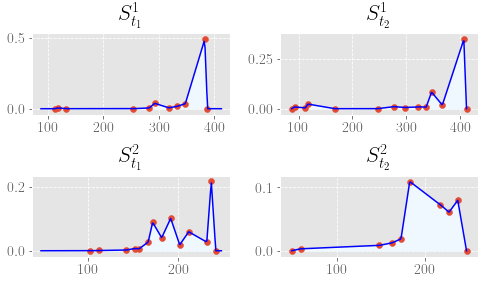

In [15]:
# fig, axs = plt.subplots(2, 2)

fig,axs = plt.subplots(2, 2,figsize = (8,4))
#fig = plt.figure(figsize = (10,10))


x11 = np.linspace(min(vv11), max(vv11), num=200, endpoint=True)
f11 = interp1d(vv11, pp11, kind='linear')
axs[0, 0].plot(x11,f11(x11),color="blue")
axs[0, 0].fill_between(x11,[0]*len(x11), f11(x11), color='aliceblue')
axs[0, 0].scatter(v11,f11(v11))
axs[0, 0].set_title(r'$S_{t_1}^1$')


x21 = np.linspace(min(vv21), max(vv21), num=200, endpoint=True)
f21 = interp1d(vv21, pp21, kind='linear')
axs[0, 1].plot(x21,f21(x21),color="blue")
axs[0, 1].fill_between(x11,[0]*len(x21), f21(x21), color='aliceblue')
axs[0, 1].scatter(v21,f21(v21))
axs[0, 1].set_title(r'$S_{t_2}^1$')


x12 = np.linspace(min(vv12), max(vv12), num=200, endpoint=True)
f12 = interp1d(vv12, pp12, kind='linear')
axs[1, 0].plot(x12,f12(x12),color="blue")
axs[1, 0].fill_between(x12,[0]*len(x12), f12(x12), color='aliceblue')
axs[1, 0].scatter(v12,f12(v12))
axs[1, 0].set_title(r'$S_{t_1}^2$')


x22 = np.linspace(min(vv22), max(vv22), num=200, endpoint=True)
f22 = interp1d(vv22, pp22, kind='linear')
axs[1, 1].plot(x22,f22(x22),color="blue")
axs[1, 1].fill_between(x22,[0]*len(x22), f22(x22), color='aliceblue')
axs[1, 1].scatter(v22,f22(v22))
axs[1, 1].set_title(r'$S_{t_2}^2$')

axs[0,0].grid(True, linestyle='--')
axs[0,1].grid(True, linestyle='--')
axs[1,0].grid(True, linestyle='--')
axs[1,1].grid(True, linestyle='--')
fig.subplots_adjust(right=0.9,top = 0.9,wspace = 0.25,hspace = 0.75)
plt.show()

U-Quantization

In [16]:
def discretize_density(density,min=0, max=10,N=10000,n=20,average=True,use_mean=False,mean_value=1):
    vv = np.linspace(min,max,N)
    epsilon = 1/n
    #Distribution Function:
    distr = np.cumsum(density(vv))/(np.cumsum(density(vv)))[-1]
    if average:
        v = np.zeros(n)
        for j in range(n-1):
            k=[]
            for i in range(N):
                if distr[i] >= ((j+1)/n - epsilon) and distr[i] < (j+1)/n :
                    k.append(vv[i])
            v[j] = np.mean(k)
        k=[]
        for i in range(N):
            if distr[i] >= (1-epsilon) and distr[i] < 1:
                k.append(vv[i])
        v[-1]=np.min(k)
        if use_mean:
            v[-1] = n*mean_value - np.sum(v[:n])
        p = np.repeat(1/n,n)
    else:
        v=np.linspace(min,max,n)
        p=density(v)
    return v,p

In [17]:
v11,p11 = discretize_density(interp1d(v11, p11, kind='linear'),min = min(v11),max = max(v11))
v12,p12 = discretize_density(interp1d(v12, p12, kind='linear'),min = min(v12),max = max(v12))
v21,p21 = discretize_density(interp1d(v21, p21, kind='linear'),min = min(v21),max = max(v21))
v22,p22 = discretize_density(interp1d(v22, p22, kind='linear'),min = min(v22),max = max(v22))
mean_11 = sum([v*p for v,p in zip(v11,p11)])
mean_21 = sum([v*p for v,p in zip(v21,p21)])
mean_12 = sum([v*p for v,p in zip(v12,p12)])
mean_22 = sum([v*p for v,p in zip(v22,p22)])
v11 = [v + 0.5*(mean_21-mean_11) for v in v11]
v21 = [v + 0.5*(mean_11-mean_21) for v in v21]
v12 = [v + 0.5*(mean_22-mean_12) for v in v12]
v22 = [v + 0.5*(mean_12-mean_22) for v in v22]

$\textbf{Compute Price Bounds given these Marginals}$

We first define the payoff functions

In [18]:
def dual_dynamic_2dim(values1,prob1,values2,prob2,func,lb = 0,ub =0, strikes = [0],
                      minimize=True, method = "gurobi"):
    n1 = len(values1)
    n2 = len(values2)
  
    
    # Defining the Cost Function
    costs = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            costs[i,j] = func(values1[i],values2[j])
    import gurobipy as gp
    from gurobipy import GRB
    m = gp.Model("m")
    m.setParam( 'OutputFlag', False )
    x = m.addMVar(shape=n1+n2+n1+len(strikes)*n1,lb = -GRB.INFINITY,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x")
    for i in range(n1):
        for j in range(n2):
            a1 = np.zeros(n1)
            a1[i] = 1
            a2 = np.zeros(n2)
            a2[j] = 1
            a3 = np.zeros(n1)
            a3[i] = (values2[j]-values1[i])
            a4 = np.zeros((n1,len(strikes)))
            # Bounds of p
            p = [[(max(values1[i]-strikes[s],0)+lb),(values1[i]-ub)] for s in range(len(strikes))]     
            for index in itertools.product([0,1],repeat = len(strikes)): #only look at extreme values of p
                for l in range(len(strikes)):
                    a4[i,l] = (max(values2[j]-strikes[l],0)-p[l][index[l]])
                lhs =  np.concatenate((a1,a2,a3,a4.reshape(-1)))
                if minimize == True:
                    m.addConstr(lhs @ x <= np.array(costs[i,j]))
                elif minimize == False:
                    m.addConstr(lhs @ x >= np.array(costs[i,j])) 
                
    # Solve Linear System
    #####################
    objective = np.concatenate((prob1,prob2,np.zeros(n1+n1*len(strikes))))
    if(minimize == True):
        m.setObjective(objective @ x, GRB.MAXIMIZE)
    elif(minimize == False):
        m.setObjective(objective @ x, GRB.MINIMIZE)
    m.optimize()
    return m.objVal, m 

def dual_2dim(values1,prob1,values2,prob2,func,minimize=True):
    n1 = len(values1)
    n2 = len(values2)
    
    # Defining the Cost Function
    costs = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
                costs[i,j] = func(values1[i],values2[j])

    import gurobipy as gp
    from gurobipy import GRB
    m = gp.Model("m")
    m.setParam( 'OutputFlag', False )
    x = m.addMVar(shape=2*n1+n2,lb = -GRB.INFINITY,ub = GRB.INFINITY, vtype=GRB.CONTINUOUS, name="x")
    for i in range(n1):
        for j in range(n2):
            a1 = np.repeat(0,n1)
            a1[i] = 1
            a2 = np.repeat(0,n2)
            a2[j] = 1
            a4 = np.zeros(n1)
            a4[i] = (values2[j]-values1[i])
            lhs =  np.concatenate((a1,a2,a4))
            if minimize == True:
                m.addConstr(lhs @ x <= np.array(costs[i,j]))
            elif minimize == False:
                m.addConstr(lhs @ x >= np.array(costs[i,j]))
        
    #print(np.unique(A, return_counts=True))
    # Solve Linear System
    #####################
    objective = np.concatenate((prob1,prob2,np.zeros(n1)))
    up_limit = None
    down_limit = None

    if(minimize == True):
        m.setObjective(objective @ x, GRB.MAXIMIZE)
    elif(minimize == False):
        m.setObjective(objective @ x, GRB.MINIMIZE)
    m.optimize()
    return m.objVal, m

# Definition of Primal Problem
def mot(*args,func,minimize=True,martingale = True,variance_info =False, variance_level = 1,variance_times = (1,2), method ="gurobi",iterations = 10e20): 
    # Importing necessary packages
    import numpy as np
    import itertools
    from scipy.optimize import linprog
    
    
    # Grab the Number of Marginals
    n= int(len(args)/2)
    
    # Grab the values and the probabilities
    values=[]
    prob=[]

    for i in range(n):
            values.append(args[2*i])
            prob.append(args[2*i+1])    
                   
    # Define necessary Variables: Length of the vectors
    N=[]
    for i in range(n):
        N.append(len(values[i]))         
   
    # Create one List containing all indices: [i_1,....,i_n,j_1,...j_n,k_1,...k_n,...]
    # where i_1,...i_n are the indices from the first marginal, j_1,...j_n the indices from 
    # the second and so on.
    indices_in_one_list = []
    for i in range(n):
        for j in range(N[i]):
                indices_in_one_list.append(j)
 
    
    # Dimensions of the Problem as Tuple:
    dimensions = ()
    for i in range(n):
        dimensions+=(N[i],)
        
    #For indexing we need the index range:        
    index_range = ()
    for i in range(n):
        index_range +=(slice(0,N[i]),)
        
    # Creating a list with all posible tuples of index combinations  
    all_tuples=[]
    # iterate over all combinations of length n
    for l in list(itertools.combinations(indices_in_one_list,n)):
        logic = 1
        # Check whether index i comes from marginal i
        for i in range(n):
            logic = logic*(l[i] in range(N[i]))
        if logic == 1 and l not in all_tuples:
            all_tuples.append(l)
    
    # Free Memory
    indices_in_one_list = 0
    # All tuples of shorter length with same beginning, i.e. cutting the longer tuples  
    tuple_shorter=[]    
    for i in range(0,n):
        tuple_shorter.append([])
        for t in all_tuples:
            if t[:i] not in tuple_shorter[i]:
                tuple_shorter[i].append(t[:i])           
    if method != "gurobi":
        # Define R.H.S vector
        ####################
        r=[]
        for i in range(n):
            for j in range(N[i]):
                r.append(prob[i][j]) # Adding the rhs values for the marginal conditions
        
        # L.H.S. Vector / Setting the size
        ##################################
        
        A = np.zeros((np.sum(dimensions),np.prod(dimensions))) # Adjusting Size only for Marginal conditions
    
        # Marginal Conditions  
        ####################
        row=0 # indicates the current row of the Matrix A
        for i in range(n):
            for j in range(N[i]):
                ind=()
                a=np.zeros(dimensions)
                for k in range(n):
                    if k != i :
                        ind += (index_range[k],)
                    elif k == i :
                        ind += (j,)
                a[ind] = 1
                A[row,:]=np.reshape(a,np.prod(dimensions))
                row+=1
                
        # Martingale Conditions       
        #######################
        # Condition: E_Q[S_i|S_{i-1},...,S_1]=S_{i-1} f.a. i=1,...,n
        if martingale:
            for i in range(1,n): # Loop over time steps
                a = np.zeros(dimensions) # will be fed with data for the measure
                for tup1 in tuple_shorter[i]: # Iteration over all possible values
                    for tup2 in all_tuples:
                        if tup2[:i] == tup1:
                            a[tup2] = values[i][tup2[i]]-values[i-1][tup2[i-1]]                      
                    # append this condition to A
                    A = np.vstack([A, np.reshape(a,np.prod(dimensions))])
                    # append a 0 to the right hand side
                    r = np.hstack([r,0])
                    row+=1
    elif method == "gurobi":
        # Build the Gurobi Model
        import gurobipy as gp
        from gurobipy import GRB
        m = gp.Model("m")
        m.setParam( 'OutputFlag', False )
        m.setParam('Method', 1)
        m.setParam('IterationLimit',iterations)
        x = m.addMVar(shape=np.int(np.prod(dimensions)),lb = 0, ub = 1, vtype=GRB.CONTINUOUS, name="x") 
        # Marginal Conditions  
        ####################
        row=0 # indicates the current row of the Matrix A
        for i in range(n):
            for j in range(N[i]):
                ind=()
                a=np.zeros(dimensions)
                for k in range(n):
                    if k != i :
                        ind += (index_range[k],)
                    elif k == i :
                        ind += (j,)
                a[ind] = 1
                m.addConstr(np.reshape(a,np.prod(dimensions)) @ x == np.array(prob[i][j]))                 
        # Martingale Conditions       
        #######################
        # Condition: E_Q[S_i|S_{i-1},...,S_1]=S_{i-1} f.a. i=1,...,n
        if martingale: 
            for i in range(1,n): # Loop over time steps
              a = np.zeros(dimensions) # will be fed with data for the measure
              for tup1 in tuple_shorter[i]: # Iteration over all possible values
                  for tup2 in all_tuples:
                      if tup2[:i] == tup1:
                          a[tup2] = values[i][tup2[i]]-values[i-1][tup2[i-1]]                      
                  # append this condition
                  m.addConstr(np.reshape(a,np.prod(dimensions)) @ x == 0) 
 
        # Variance Information
        ###########################
        # Condition: E_Q[(S_n/S_(n-1))^2]=sigma^2+1
        if variance_info:
            time_1 = variance_times[0]
            time_2 = variance_times[1]
            a = np.zeros(dimensions) # will be fed with data for the measure
            for tup in all_tuples:
                a[tup] = (values[time_2-1][tup[time_2-1]]/values[time_1-1][tup[time_1-1]])**2
                # append this condition
            m.addConstr(np.reshape(a,np.prod(dimensions)) @ x == variance_level+1)
                
    # Define Payoff/Cost Array
    #########################
            
    # Function that returns correpsonding values to some given tuple,
    # e.g. (3,5,1,2) - > (values[1][3],values[2][5],values[3][1],values[4][2])
    def ind_to_value(index_tuple):
        v=()
        for i in range(n):
            v+=(values[i][index_tuple[i]],)
        return v
     
    costs = np.zeros(dimensions)    
    for tuple in all_tuples:
            costs[tuple] = func(*ind_to_value(tuple))
    costs = np.reshape(costs,np.prod(dimensions))           
  
   
    # Solve Linear System
    #####################
    if method != "gurobi":
        if(minimize == True):
            res = linprog(costs, A_eq=A, b_eq=r, bounds=(0,1),  options={"disp": False}, method = "interior-point")
        elif(minimize == False):
            res = linprog(-costs, A_eq=A, b_eq=r, bounds=(0,1),  options={"disp": False}, method = "interior-point")
        if res.success:
            # print out optimal q and optimal price
            q = res["x"]
            if(minimize == True):
                price = res["fun"]
            else:
                price = -res["fun"]            
            return price, q
        else:
            print("linprog failed:", res.message)
    elif method == "gurobi":
        if minimize == True:
            m.setObjective(costs @ x, GRB.MINIMIZE)
        elif minimize == False:
            m.setObjective(costs @ x, GRB.MAXIMIZE)
        m.optimize()
        price = m.objVal
        q = m
        return price, np.array(m.x)
    

# Examples 

Define Strikes

In [19]:
strikes = np.linspace(360,360,1)

Define the Payoffs

In [20]:
# We use the same payoff functions as always

def payoff1(a,b):
    return np.abs(a-b)

def payoff2(a,b):
    return np.maximum(np.maximum(a,b)-360,0)

def payoff3(a,b):
    return np.maximum(0.5*(a+b)-350,0)

def payoff4(a,b):
    return np.abs(a*1.1-b)


In [21]:
print("Lower Bound")
print("Without Options")
print(dual_2dim(v11,p11,v21,p21,func=payoff1,minimize=True)[0])
print("With Options")
print(dual_dynamic_2dim(v11,p11,v21,p21,func=payoff1,minimize=True,
                        strikes = strikes)[0])
print("Upper Bound")
print("With Options")
print(dual_dynamic_2dim(v11,p11,v21,p21,func=payoff1, strikes = strikes,minimize=False)[0])
print("Without Options")
print(dual_2dim(v11,p11,v21,p21,func=payoff1,minimize=False)[0])

Lower Bound
Without Options
Using license file C:\Users\Julian\gurobi.lic
Academic license - for non-commercial use only
26.509987394442298
With Options
26.509987394442305
Upper Bound
With Options
43.54361772296548
Without Options
43.54361772296548


We define a function to compute the bounds from which on we expect improvement.

Compute the first $\varepsilon$ such that
$\overline{p}_{i,j,k}-\varepsilon = \mathbb{E}_{\mathbb{Q}^*}[(S_{t_j}-K)^+|S_{t_1}]$
and 
$\underline{p}_{i,j,k}-\varepsilon = \mathbb{E}_{\mathbb{Q}^*}[(S_{t_j}-K)^+|S_{t_1}]$
respectively for $\overline{p}_{i,j,k} = S_{t_1}$ and $\underline{p}_{i,j,k}=(S_{t_1}-K)^+$.

In [22]:
# Grab the optimal measure
optimal_measure1 = mot(v11,p11,v21,p21,func=payoff1,minimize=False)[1].reshape(20,20)
optimal_measure2 = mot(v11,p11,v21,p21,func=payoff2,minimize=False)[1].reshape(20,20)
optimal_measure3 = mot(v11,p11,v21,p21,func=payoff3,minimize=False)[1].reshape(20,20)
optimal_measure4 = mot(v11,p11,v21,p21,func=payoff4,minimize=False)[1].reshape(20,20)

#Define the function for the computation of the bounds
def compute_bounds(Q,p11,v11,p21,v21,set_of_strikes,lower_epsilon = False):
    cond_expectation = np.zeros((len(v11),len(set_of_strikes)))
    for K in range(len(set_of_strikes)):
        for i in range(len(v11)):
            cond_expectation[i,K] = np.sum([(Q[i,j]/p11[i])*(max(v21[j]-set_of_strikes[K],0)) for j in range(len(v21))])
            if lower_epsilon:
                cond_expectation[i,K] = cond_expectation[i,K] - (max(v11[i]-set_of_strikes[K],0))
            else:
                cond_expectation[i,K] = v11[i]-cond_expectation[i,K]
    if lower_epsilon:
        return min(cond_expectation.min(axis = 1)), cond_expectation.reshape(-1)
    elif lower_epsilon == False:
        return min(cond_expectation.min(axis = 1)), cond_expectation.reshape(-1)
    
upper_critical_points1 = compute_bounds(optimal_measure1,p11,v11,p21,v21,strikes,lower_epsilon = False)
lower_critical_bounds1 = compute_bounds(optimal_measure1,p11,v11,p21,v21,strikes,lower_epsilon = True)
upper_critical_points2 = compute_bounds(optimal_measure2,p11,v11,p21,v21,strikes,lower_epsilon = False)
lower_critical_bounds2 = compute_bounds(optimal_measure2,p11,v11,p21,v21,strikes,lower_epsilon = True)
upper_critical_points3 = compute_bounds(optimal_measure3,p11,v11,p21,v21,strikes,lower_epsilon = False)
lower_critical_bounds3 = compute_bounds(optimal_measure3,p11,v11,p21,v21,strikes,lower_epsilon = True)
upper_critical_points4 = compute_bounds(optimal_measure4,p11,v11,p21,v21,strikes,lower_epsilon = False)
lower_critical_bounds4 = compute_bounds(optimal_measure4,p11,v11,p21,v21,strikes,lower_epsilon = True)

Computation of the bounds

In [23]:
def compute_increase(v11,p11,v21,p21,payoff1,strikes,eps_1 = 5,eps_2 = 175):
    original_bound = dual_2dim(v11,p11,v21,p21,func=payoff1,minimize=False)[0]
    #Increase in lower bound
    lower_bound1 = []
    lbs = np.linspace(0,eps_1,150)
    for lb in lbs:
        try:
            lower_bound1+= [dual_dynamic_2dim(v11,p11,v21,p21,func=payoff1,minimize=False,
                                lb =lb,ub = 0, strikes = strikes)[0]]
        except:
            lower_bound1 += ["NoNumber"]
    valid_indices1 = [i for i in range(150) if lower_bound1[i]!="NoNumber"]
    lower_bound1 = [lower_bound1[i] for i in valid_indices1]
    lbs = [lbs[i] for i in valid_indices1]

    #Decrease in upper bound
    lower_bound2 = []
    ubs = np.linspace(eps_2,strikes[0],150)
    for ub in ubs:
        try:
            lower_bound2+= [dual_dynamic_2dim(v11,p11,v21,p21,func=payoff1,minimize=False,
                                lb =0,ub = ub, strikes = strikes)[0]]
        except:
            lower_bound2 += ["NoNumber"]
    valid_indices2 = [i for i in range(150) if lower_bound2[i]!="NoNumber"]
    lower_bound2 = [lower_bound2[i] for i in valid_indices2]
    ubs = [ubs[i] for i in valid_indices2]
    return original_bound, lbs, lower_bound1, ubs, lower_bound2

Plotting of the bounds

In [24]:
def points_pa(x,y,eps = 0.0001):
    diff_y = np.diff(y)
    indices = []
    for i in range(1,len(diff_y)):
        if abs(diff_y[i] -diff_y[i-1]) > eps:
            indices += [i]
    return indices  

In [25]:
def plot_improvement(original_bound,lbs, lower_bound1, ubs, lower_bound2,payoff,payoff_name,save_name = "name",save = False):
    # Interpolate the bound functions
    interpol1 = interp1d(lbs,lower_bound1)
    interpol2 = interp1d(ubs,lower_bound2)

#     optimal_measure1 = mot(v11,p11,v21,p21,func=payoff,minimize=False)[1].reshape(20,20)
#     upper_critical_points1 = compute_bounds(optimal_measure1,p11,v11,p21,v21,strikes,lower_epsilon = False)
#     lower_critical_bounds1 = compute_bounds(optimal_measure1,p11,v11,p21,v21,strikes,lower_epsilon = True)
#     lower_critical1 = [round(u,5) for u in lower_critical_bounds1[1] if (round(u,5) <= round(max(lbs),5))*(round(u,5) >= round(min(lbs),5))]
#     upper_critical1 = [round(u,5) for u in upper_critical_points1[1] if (round(u,5) <= round(max(ubs),5))*(round(u,5) >= round(min(ubs),5))]
    
    # Create Subplots
    fig, axs = plt.subplots(1,2,figsize = (10,3))
    fig.suptitle(payoff_name)
    plt.gcf().subplots_adjust(left=0.2,wspace = 0.5,bottom =0.25)

    # Plotting of the resultant functions and the points from which on we expect improvement
    line = axs[0].plot(lbs,lower_bound1,color = "steelblue")
    axs[0].set(xlabel=r'$\varepsilon$', ylabel=r'$P_{\Xi_{(\underline{p}_{i,j,k}+\varepsilon,\overline{p}_{i,j,k})}}(\Phi)$')
#    axs[0].scatter(lower_critical1,interpol1(lower_critical1),color = "steelblue")
    axs[0].plot([lbs[0],lbs[-1]],[original_bound,original_bound],linestyle='dashed',color = "black")
#     change_idx = points_pa(lbs,lower_bound1)
#     changes_pts_x1 = [lbs[i] for i in change_idx]
#     changes_pts_y1 = [lower_bound1[i] for i in change_idx]
#     axs[0].scatter(changes_pts_x1,changes_pts_y1,color = "steelblue",s=15,marker = "x")
    axs[1].plot(ubs,lower_bound2,color = "steelblue")
    axs[1].set(xlabel=r"$\varepsilon$", ylabel=r'$P_{\Xi_{(\underline{p}_{i,j,k},\overline{p}_{i,j,k}-\varepsilon)}}(\Phi)$')
#    axs[1].scatter(upper_critical1,interpol2(upper_critical1),color = "steelblue")
    axs[1].plot([ubs[0],ubs[-1]],[original_bound,original_bound],linestyle='dashed',color = "black")
#     change_idx = points_pa(ubs,lower_bound2)
#     changes_pts_x1 = [ubs[i] for i in change_idx]
#     changes_pts_y1 = [lower_bound2[i] for i in change_idx]
#     axs[1].scatter(changes_pts_x1,changes_pts_y1,color = "steelblue",s=15,marker = "x")
    if save:
        plt.savefig(save_name, dpi=150)
    return axs, fig, line

In [26]:
def plot_improvement_in_existing_plot(axs,fig,original_bound,lbs, lower_bound1, ubs, lower_bound2,payoff,save_name = "None",color="red",linestyle ="dotted",save = False):
    # Interpolate the bound functions
#    interpol1 = interp1d(lbs,lower_bound1)
#    interpol2 = interp1d(ubs,lower_bound2)
#    optimal_measure1 = mot(v11,p11,v21,p21,func=payoff,minimize=False)[1].reshape(20,20)
#     upper_critical_points1 = compute_bounds(optimal_measure1,p11,v11,p21,v21,strikes,lower_epsilon = False)
#     lower_critical_bounds1 = compute_bounds(optimal_measure1,p11,v11,p21,v21,strikes,lower_epsilon = True)
#     lower_critical1 = [round(u,5) for u in lower_critical_bounds1[1] if (round(u,5) <= round(max(lbs),5))*(round(u,5) >= round(min(lbs),5))]
#     upper_critical1 = [round(u,5) for u in upper_critical_points1[1] if (round(u,5) <= round(max(ubs),5))*(round(u,5) >= round(min(ubs),5))]
  

    # Plotting of the resultant functions and the points from which on we expect improvement
    line = axs[0].plot(lbs,lower_bound1,linestyle=linestyle,color = color)
 #   axs[0].scatter(lower_critical1,interpol1(lower_critical1),color = "red")
#     change_idx = points_pa(lbs,lower_bound1)
#     changes_pts_x1 = [lbs[i] for i in change_idx]
#     changes_pts_y1 = [lower_bound1[i] for i in change_idx]
#     axs[0].scatter(changes_pts_x1,changes_pts_y1,color = color,s=15,marker = "x")
    
    axs[1].plot(ubs,lower_bound2,linestyle=linestyle,color =color)
#     change_idx = points_pa(ubs,lower_bound2)
#     changes_pts_x1 = [ubs[i] for i in change_idx]
#     changes_pts_y1 = [lower_bound2[i] for i in change_idx]
#     axs[1].scatter(changes_pts_x1,changes_pts_y1,color = color,s=15,marker = "x")
#    axs[1].scatter(upper_critical1,interpol2(upper_critical1),color = "red")
    if save:
        plt.savefig(save_name, dpi=150)
        plt.show()        
    return axs, fig, line

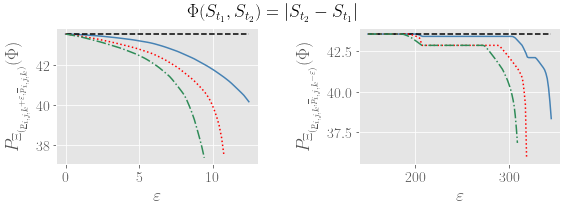

In [27]:
strikes1 = [360]
strikes2 = [340,360]
strikes3 = [320,340,360]

original_bound, l1a, lb1a, u1a, ub1a = compute_increase(v11,p11,v21,p21,payoff1,strikes1,eps_1 = 25,eps_2 = 150)
axs1, fig1, line1 = plot_improvement(original_bound,l1a, lb1a, u1a, ub1a,payoff1,r'$\Phi(S_{t_1},S_{t_2})=|S_{t_2}-S_{t_1}|$')

original_bound, l2a, lb2a, u2a, ub2a = compute_increase(v11,p11,v21,p21,payoff1,strikes2,eps_1 = 25,eps_2 = 150)
axs2, fig2, line2 = plot_improvement_in_existing_plot(axs1,fig1,original_bound,l2a, lb2a, u2a, ub2a,payoff1,linestyle ="dotted")

original_bound, l3a, lb3a, u3a, ub3a = compute_increase(v11,p11,v21,p21,payoff1,strikes3,eps_1 = 25,eps_2 = 150)
axs3, fig3, line3 = plot_improvement_in_existing_plot(axs2,fig2,original_bound,l3a, lb3a, u3a, ub3a,payoff1,"real_impro_1.eps",color="seagreen",linestyle ="dashdot",save = True)

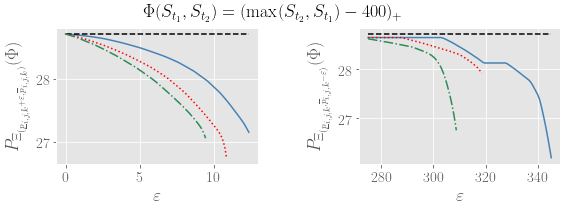

In [28]:
strikes1 = [360]
strikes2 = [340,360]
strikes3 = [320,340,360]

original_bound, l1b, lb1b, u1b, ub1b = compute_increase(v11,p11,v21,p21,payoff2,strikes1,eps_1 = 15,eps_2 = 275)
axs1, fig1, line1 = plot_improvement(original_bound,l1b, lb1b, u1b, ub1b,payoff2,r'$\Phi(S_{t_1},S_{t_2})=(\max(S_{t_2},S_{t_1})-400)_+$')
original_bound, l2b, lb2b, u2b, ub2b = compute_increase(v11,p11,v21,p21,payoff2,strikes2,eps_1 = 15,eps_2 = 275)
axs2, fig2, line2 = plot_improvement_in_existing_plot(axs1,fig1,original_bound,l2b, lb2b, u2b, ub2b,payoff2,linestyle ="dotted")
original_bound, l3b, lb3b, u3b, ub3b = compute_increase(v11,p11,v21,p21,payoff2,strikes3,eps_1 = 15,eps_2 = 275)
axs3, fig3, line3 = plot_improvement_in_existing_plot(axs2,fig2,original_bound,l3b, lb3b, u3b, ub3b,payoff2,"real_impro_2.eps",color="seagreen",linestyle ="dashdot",save = True)



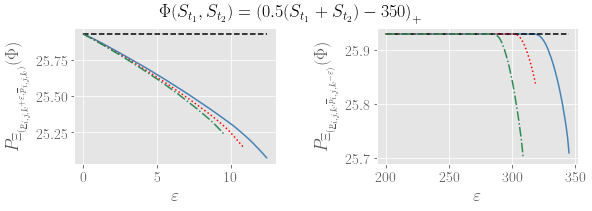

In [29]:
strikes1 = [360]
strikes2 = [340,360]
strikes3 = [320,340,360]

original_bound, l1c, lb1c, u1c, ub1c = compute_increase(v11,p11,v21,p21,payoff3,strikes1,eps_1 = 15,eps_2 = 200)
axs1, fig1, line1 = plot_improvement(original_bound,l1c, lb1c, u1c, ub1c,payoff3,r'$\Phi(S_{t_1},S_{t_2})=\left(0.5(S_{t_1}+S_{t_2})-350\right)_+$')
original_bound, l2c, lb2c, u2c, ub2c = compute_increase(v11,p11,v21,p21,payoff3,strikes2,eps_1 = 15,eps_2 = 200)
axs2, fig2, line2 = plot_improvement_in_existing_plot(axs1,fig1,original_bound,l2c, lb2c, u2c, ub2c,payoff3,linestyle ="dotted")
original_bound, l3c, lb3c, u3c, ub3c = compute_increase(v11,p11,v21,p21,payoff3,strikes3,eps_1 = 15,eps_2 = 200)
axs3, fig3, line3 = plot_improvement_in_existing_plot(axs2,fig2,original_bound,l3c, lb3c, u3c, ub3c,payoff3,"real_impro_3.eps",color="seagreen",linestyle ="dashdot",save = True)


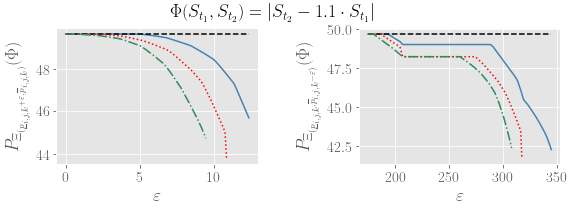

In [30]:
strikes1 = [360]
strikes2 = [340,360]
strikes3 = [320,340,360]

original_bound, l1d, lb1d, u1d, ub1d = compute_increase(v11,p11,v21,p21,payoff4,strikes1,eps_1 = 15,eps_2 = 175)
axs1, fig1, line1 = plot_improvement(original_bound,l1d, lb1d, u1d, ub1d,payoff4,r'$\Phi(S_{t_1},S_{t_2})=|S_{t_2}-1.1\cdot S_{t_1}|$')
original_bound, l2d, lb2d, u2d, ub2d = compute_increase(v11,p11,v21,p21,payoff4,strikes2,eps_1 = 15,eps_2 = 175)
axs2, fig2, line2 = plot_improvement_in_existing_plot(axs1,fig1,original_bound,l2d, lb2d, u2d, ub2d,payoff4,linestyle ="dotted")
original_bound, l3d, lb3d, u3d, ub3d = compute_increase(v11,p11,v21,p21,payoff4,strikes3,eps_1 = 15,eps_2 = 175)
axs3, fig3, line3 = plot_improvement_in_existing_plot(axs2,fig2,original_bound,l3d, lb3d, u3d, ub3d,payoff4,"real_impro_4.eps",color="seagreen",linestyle ="dashdot",save = True)


Now we create, plot and save the legend

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


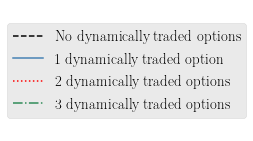

In [31]:
first = [1]
second = [1]
third = [1]
fourth = [1]
plt.figure(figsize=(4,2))
plt.plot(first,linestyle='dashed',color = "black")
plt.plot(second,color = "steelblue")
plt.plot(third,linestyle='dotted',color = "red")
plt.plot(fourth,linestyle='dashdot',color = "seagreen")
plt.legend(['No dynamically traded options', '1 dynamically traded option','2 dynamically traded options','3 dynamically traded options'],
           loc='center')
plt.axis('off')
plt.gcf().subplots_adjust(left=0.2,bottom = 0)
plt.savefig("legend_real.eps", dpi=100)
plt.show()